In [1]:
import findspark
findspark.init()
import pyspark

In [ ]:
from pyspark import SparkContext
sc = SparkContext()

In [2]:
# You can create SparkContext from a Spark Session
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

## Important Terms

Let's quickly go over some important terms:

Term                   |Definition
----                   |-------
RDD                    |Resilient Distributed Dataset
Transformation         |Spark operation that produces an RDD
Action                 |Spark operation that produces a local object
Spark Job              |Sequence of transformations on data with a final action

## Creating an RDD

There are two ways to create RDDs: <b>parallelizing</b> an existing collection in your driver program, or <b>referencing a dataset</b> in an external storage system, such as a shared filesystem, HDFS, HBase, or any data source offering a Hadoop InputFormat.

Method                      |Result
----------                               |-------
`sc.parallelize(array)`                  |Create RDD of elements of array (or list)
`sc.textFile(path/to/file)`                      |Create RDD of lines from file

In [ ]:
data = [1, 2, 3, 4, 5]
distDataRDD = sc.parallelize(data)

In [ ]:
distDataRDD.collect()

##### Once created, the distributed dataset (distDataRDD) can be operated on in parallel.

In [ ]:
 distDataRDD.reduce(lambda a, b: a + b)

PySpark can create distributed datasets from any storage source supported by Hadoop, including your local file system, HDFS, Cassandra, HBase, Amazon S3, etc. Spark supports text files, SequenceFiles, and any other Hadoop InputFormat.

In [3]:
%%writefile example.txt
first line
second line
third line
fourth line

Writing example.txt


In [4]:
distFile = sc.textFile('example.txt')

In [5]:
distFile

example.txt MapPartitionsRDD[1] at textFile at NativeMethodAccessorImpl.java:0

In [14]:
distFile.getNumPartitions()

2

In [6]:
distFile.count()

4

In [15]:
distFile.first()

'first line'

In [16]:
distFile.collect()

['first line', 'second line', 'third line', 'fourth line']

In [17]:
lst = distFile.collect()

In [18]:
lst[0]

'first line'

In [19]:
secfind = distFile.filter(lambda line: 'second' in line)

In [20]:
secfind.collect()

['second line']

In [21]:
thrdfind = distFile.filter(lambda line: 'third' in line)

In [22]:
thrdfind.collect()

['third line']

In [23]:
 distFile_mapped = distFile.map(lambda s: len(s))

In [24]:
distFile_mapped.collect()

[10, 11, 10, 11]

In [25]:
distFile_mapped.reduce(lambda a, b: a + b)

42

## RDD Transformations

We can use transformations to create a set of instructions we want to preform on the RDD (before we call an action and actually execute them).

Transformations are the process which are used to create a new RDD. It follows the principle of Lazy Evaluations (the execution will not start until an action is triggered).

Transformation Example                          |Result
----------                               |-------
`filter(lambda x: x % 2 == 0)`           |Discard non-even elements
`map(lambda x: x * 2)`                   |Multiply each RDD element by `2`
`map(lambda x: x.split())`               |Split each string into words
`flatMap(lambda x: x.split())`           |Split each string into words and flatten sequence
`sample(withReplacement=True,0.25)`      |Create sample of 25% of elements with replacement
`union(rdd)`                             |Append `rdd` to existing RDD
`distinct()`                             |Remove duplicates in RDD
`sortBy(lambda x: x, ascending=False)`   |Sort elements in descending order

## RDD Actions

Once you have your 'recipe' of transformations ready, what you will do next is execute them by calling an action.

Actions are the processes which are applied on an RDD to initiate Apache Spark to apply calculation and pass the result back to driver. 

Here are some common actions:

Action                             |Result
----------                             |-------
`collect()`                            |Convert RDD to in-memory list 
`take(3)`                              |First 3 elements of RDD 
`top(3)`                               |Top 3 elements of RDD
`takeSample(withReplacement=True,3)`   |Create sample of 3 elements with replacement
`sum()`                                |Find element sum (assumes numeric elements)
`mean()`                               |Find element mean (assumes numeric elements)
`stdev()`                              |Find element deviation (assumes numeric elements)

In [26]:
%%writefile example2.txt
first 
second line
the third line
then a fourth line

Writing example2.txt


In [27]:
# Show RDD
sc.textFile('example2.txt')

example2.txt MapPartitionsRDD[11] at textFile at NativeMethodAccessorImpl.java:0

In [28]:
# Save a reference to this RDD
text_rdd = sc.textFile('example2.txt')

In [29]:
text_rdd.take(2)

['first ', 'second line']

In [30]:
text_rdd.collect()

['first ', 'second line', 'the third line', 'then a fourth line']

### Exercise

Create a file `sample.txt`with. Read and load it into a RDD with the `textFile` spark function.

### Collect

Action / To Driver: Return all items in the RDD to the driver in a single list

![](http://i.imgur.com/DUO6ygB.png)

In [31]:
text_rdd.collect()

['first ', 'second line', 'the third line', 'then a fourth line']

### Exercise 

Collect the text you read before from the `sample.txt`file.

## Transformation

<b>Narrow transformation — </b>In Narrow transformation, all the elements that are required to compute the records in single partition live in the single partition of parent RDD. A limited subset of partition is used to calculate the result. Narrow transformations are the result of map(), filter().

<b>Wide transformation — </b>In wide transformation, all the elements that are required to compute the records in the single partition may live in many partitions of parent RDD. The partition may live in many partitions of parent RDD. Wide transformations are the result of groupbyKey and reducebyKey.<br>
<I><b> You will often hear this referred to as a shuffle where Spark will exchange partitions across the cluster.</b></I>

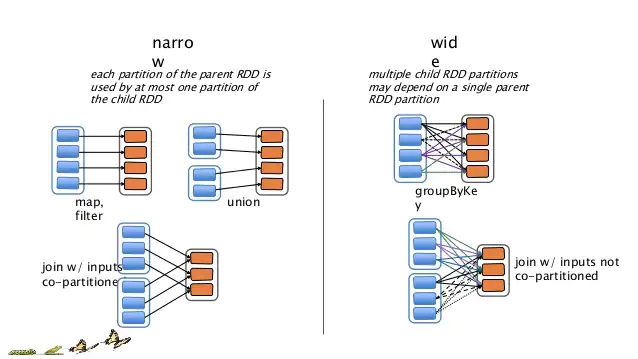

### Map

Transformation / Narrow: Return a new RDD by applying a function to each element of this RDD

![](http://i.imgur.com/PxNJf0U.png)

In [32]:
rdd = sc.parallelize(list(range(8)))
print('rdd elements:         ',rdd.collect())
rdd_squared = rdd.map(lambda x: x ** 2).collect() # Square each element
print('rdd elements squared: ', rdd_squared)

rdd elements:          [0, 1, 2, 3, 4, 5, 6, 7]
rdd elements squared:  [0, 1, 4, 9, 16, 25, 36, 49]


In [33]:
def sq(no):
    return no**2

rdd = sc.parallelize(list(range(8)))
print('rdd elements:         ',rdd.collect())
rdd_squared = rdd.map(sq).collect() # Square each element
print('rdd elements squared: ', rdd_squared)

rdd elements:          [0, 1, 2, 3, 4, 5, 6, 7]
rdd elements squared:  [0, 1, 4, 9, 16, 25, 36, 49]


In [34]:
# Map a function (or lambda expression) to each line
# Then collect the results.
text_rdd.map(lambda line: line.split()).collect()

[['first'],
 ['second', 'line'],
 ['the', 'third', 'line'],
 ['then', 'a', 'fourth', 'line']]

In [36]:
textRddlst = text_rdd.map(lambda line: line.split()).collect()

In [39]:
textRddlst[1]

['second', 'line']

In [40]:
textRddlst[1][0]

'second'

### Exercise

1- Create rdd from list of numbers and apply any built in Math function to it.<br>
2- Apply ant math operation using lambda expression.

## Map vs flatMap

### FlatMap

Transformation / Narrow: Return a new RDD by first applying a function to all elements of this RDD, and then flattening the results

![](http://i.imgur.com/TsSUex8.png)

In [42]:
text_rdd.map(lambda line: line.split()).collect()

[['first'],
 ['second', 'line'],
 ['the', 'third', 'line'],
 ['then', 'a', 'fourth', 'line']]

In [41]:
## Map vs flatMap
# Collect everything as a single flat map
text_rdd.flatMap(lambda line: line.split()).collect()

['first',
 'second',
 'line',
 'the',
 'third',
 'line',
 'then',
 'a',
 'fourth',
 'line']

In [43]:
lstFlatMap = text_rdd.flatMap(lambda line: line.split()).collect()

In [44]:
lstFlatMap[8] 

'fourth'

### Filter

Transformation / Narrow: Return a new RDD containing only the elements that satisfy a predicate

![](http://i.imgur.com/GFyji4U.png)

In [45]:
rdd.collect()

[0, 1, 2, 3, 4, 5, 6, 7]

In [50]:
# Select only the even elements
rdd.filter(lambda x: x % 2 == 0).collect()

[0, 2, 4, 6]

### GroupBy

Transformation / Wide: Group the data in the original RDD. Create pairs where the key is the output of a user function, and the value is all items for which the function yields this key.

![](http://i.imgur.com/gdj0Ey8.png)

In [51]:
rdd = sc.parallelize(['John', 'Fred', 'Anna', 'James'])
rdd = rdd.groupBy(lambda w: w[0])
rdd.collect()

[('J', <pyspark.resultiterable.ResultIterable at 0x7f14485d08e0>),
 ('F', <pyspark.resultiterable.ResultIterable at 0x7f14485ccfa0>),
 ('A', <pyspark.resultiterable.ResultIterable at 0x7f14485cc7f0>)]

In [53]:
rdd.first()

('J', <pyspark.resultiterable.ResultIterable at 0x7f14480c4340>)

In [56]:
rdd.first()[1]

In [57]:
list(rdd.first()[1])

['John', 'James']

In [58]:
[(k, list(v)) for (k, v) in rdd.collect()]

[('J', ['John', 'James']), ('F', ['Fred']), ('A', ['Anna'])]

### GroupByKey

Transformation / Wide: Group the values for each key in the original RDD. Create a new pair where the original key corresponds to this collected group of values.

![](http://i.imgur.com/TlWRGr2.png)

In [59]:
rdd = sc.parallelize([('B',5),('B',4),('A',3),('A',2),('A',1)])
rdd = rdd.groupByKey()
rdd.collect()

[('B', <pyspark.resultiterable.ResultIterable at 0x7f14480bd610>),
 ('A', <pyspark.resultiterable.ResultIterable at 0x7f14480af7c0>)]

In [60]:
[(j[0], list(j[1])) for j in rdd.collect()]

[('B', [5, 4]), ('A', [3, 2, 1])]

### Join

Transformation / Wide: Return a new RDD containing all pairs of elements having the same key in the original RDDs

![](http://i.imgur.com/YXL42Nl.png)

In [61]:
x = sc.parallelize([("a", 1), ("b", 2)])
y = sc.parallelize([("a", 3), ("a", 4), ("b", 5)])
x.join(y).collect()

[('b', (2, 5)), ('a', (1, 3)), ('a', (1, 4))]

### Distinct

Transformation / Wide: Return a new RDD containing distinct items from the original RDD (omitting all duplicates)

![](http://i.imgur.com/Vqgy2a4.png)

In [62]:
rdd = sc.parallelize([1,2,3,3,4])
rdd.distinct().collect()

[2, 4, 1, 3]

### KeyBy

Transformation / Narrow: Create a Pair RDD, forming one pair for each item in the original RDD. The pair’s key is calculated from the value via a user-supplied function.

![](http://i.imgur.com/nqYhDW5.png)

In [63]:
rdd = sc.parallelize(['John', 'Fred', 'Anna', 'James'])
rdd.keyBy(lambda w: w[0]).collect()

[('J', 'John'), ('F', 'Fred'), ('A', 'Anna'), ('J', 'James')]

## Actions

![](http://i.imgur.com/R72uzwX.png)

In [64]:
rdd = sc.parallelize(list(range(8)))
rdd.map(lambda x: x ** 2).reduce(lambda a,b : a+b) # reduce is an action!

140

In [65]:
from operator import add
rdd = sc.parallelize(list(range(8)))
rdd.map(lambda x: x ** 2).collect() 

[0, 1, 4, 9, 16, 25, 36, 49]

In [66]:
rdd.map(lambda x: x ** 2).reduce(add) # reduce is an action!

140

## Exercise
### Max, Min, Sum, Mean, Variance, Stdev

Action / To Driver: Compute the respective function (maximum value, minimum value, sum, mean, variance, or standard deviation) from a numeric RDD

![](http://i.imgur.com/HUCtib1.png)

In [ ]:
# Using actions
print('Max: ',rdd.map(lambda x: x ** 2).max())
print('Min: ',rdd.map(lambda x: x ** 2).min())
print('Sum: ',rdd.map(lambda x: x ** 2).sum())
print('Mean: ',rdd.map(lambda x: x ** 2).mean())
print('Variance: ',rdd.map(lambda x: x ** 2).variance())
print('Stdev: ',rdd.map(lambda x: x ** 2).stdev())

### CountByKey

Action / To Driver: Return a map of keys and counts of their occurrences in the RDD

![](http://i.imgur.com/jvQTGv6.png)

In [67]:
rdd = sc.parallelize([('J', 'James'), ('F','Fred'), 
                    ('A','Anna'), ('J','John')])

rdd.countByKey()

defaultdict(int, {'J': 2, 'F': 1, 'A': 1})

In [68]:
# Stop the local spark cluster
sc.stop()

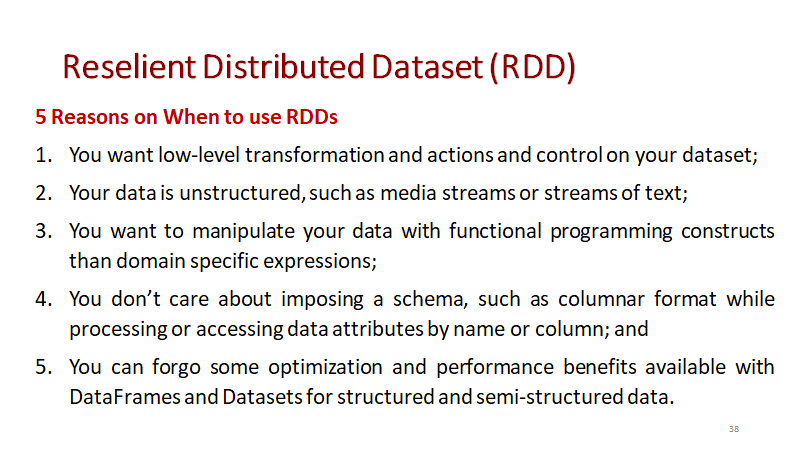